# Tutorials

## skultrafast.dataset

skultrafast is a package mainly for working with time-resolved spectra. The notebook shows how to use the new dataset-class to work with such a spectra and to fit it with a exponetial model. First we import the necessary modules and configure matplotlib to show inline graphics.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skultrafast.dataset import DataSet
import skultrafast
from skultrafast import data_io
skultrafast.__version__

pyopencl not found, using numba-basefunctions


'0.2.1+66.g4f3b9eb.dirty'

In [2]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (4,3)
plt.rcParams['font.size'] = 9


### Creating a DataSet
In this tuturial we use the example data which is provided by *skultrafast*. 

In [3]:
wavelengths, t_ps, data_mOD = data_io.load_example()

Lets look at the constructor of the `DataSet` class:

In [4]:
?DataSet

Init signature: DataSet(wl, t, data, err=None, name=None, freq_unit='nm', disp_freq_unit=None, auto_plot=True)
Docstring:      <no docstring>
Init docstring:
Class for working with time-resolved spectra. If offers methods for
analyzing and pre-processing the data. To visualize the data,
each `DataSet` object has an instance of an `DataSetPlotter` object
accessible under `plot`.

Parameters
----------
wl : array of shape(n)
    Array of the spectral dimension
t : array of shape(m)
    Array with the delay times.
data : array of shape(n, m)
    Array with the data for each point.
err : array of shape(n, m) or None (optional)
    Contains the std err of the data, can be `None`.
name : str (optional)
    Identifier for data set.
freq_unit : 'nm' or 'cm' (optional)
    Unit of the wavelength array, default is 'nm'.
disp_freq_unit : 'nm','cm' or None (optional)
    Unit which is used by default for plotting. If `None`, it defaults
    to `freq_unit`.

Attributes
----------
wavelengths, waven

As we see, we have all the necessay variables, additionlly we can name the dataset. Since the `freq_unit` defaults to 'nm' we don't need to supply this argument.

In [5]:
ds = DataSet(wavelengths, t_ps, data_mOD, name="Al(tpfc)(py)_2")

### Overview map

To get an general idea of a transient spectra is to plot some data.  All plotting functions are in the `DataSet.plot` object, which is an instance of `DataSetPlotter`. The plotting functions are using the `disp_freq_unit` of the dataset as frequency scale by default. This can be changed by changing the `disp_freq_unit` of the `DataSetPlotter` object. 

In [6]:
ds.plot.disp_freq_unit = 'nm' # does nothing, since 'nm' is the default
# ds.plot.disp_freq_unit = 'cm' would use wavenumbers

First, we want to check if the dataset is corrected for dispersion. For that we plot a colormap around the time-zero. 

(-2, 2)

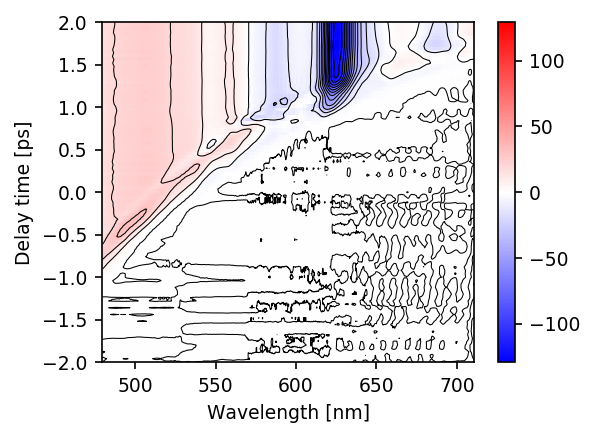

In [7]:
ds.plot.map(symlog=0, con_step=10., con_filter=(3, 10))
plt.ylim(-2, 2)

Evidently, the dataset is not corrected for dispersion. Since it is easier to work with a dispersion corrected dataset, we try to get an estimate of the dispersion using the data directly. 

### Dispersion estimation and correction
*skultrafast* does this by first using a simple heuristic for determining the time-zero for each transient. The resulting dispersion curve is then fitted with a polynomial, using a robust fitting method. More details are given in the documentation.

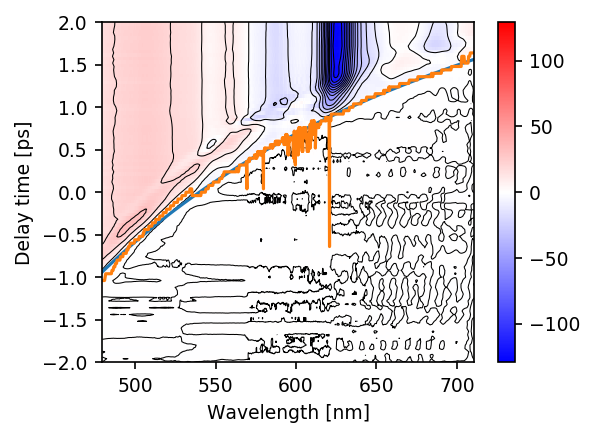

In [8]:
# First calculate and plot the estimate.
res = ds.estimate_dispersion(heuristic_args=(1.5,), deg=2)
ds.plot.map(symlog=0, con_step=10., con_filter=(3, 10))
plt.ylim(-2, 2)
plt.plot(ds.wavelengths, res.polynomial(ds.wavenumbers)) #The polynomial is defined in wavenumbers
plt.plot(ds.wavelengths, res.tn)

By default, *skultrafast* uses a very simple heuristic to find the time-zero. It looks for the earliest value above a given limit in each transient, and therefore underestimates the time-zero systematically. Therefore we slightly shift the time-zero. 

This generallay works surprinsingly well. But if the exact time-zero is necessary, I recommend to try other methods or measure the dispersion directly.

**WARNING**: The cell below changes the dataset inplace. Therefore repeated calls to the cell will shift the time-zero again and again.

In [9]:
new_ds = res.correct_ds #warning, this does not copy the dataset.
new_ds.t -= 0.2

### Plotting spectra and transients
*skultrafast* has serveral convenience functions for generating figures. Starting with the colormap from above:

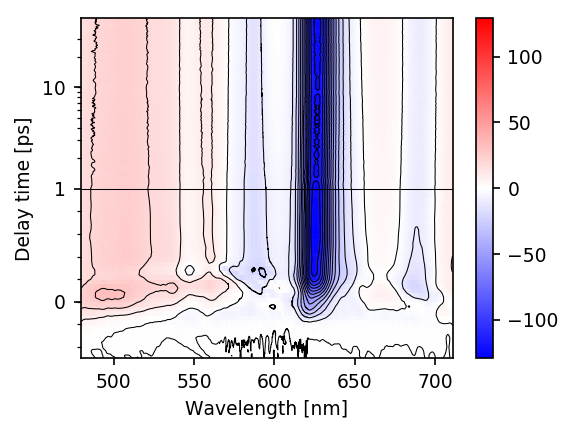

In [10]:
new_ds.plot.map(con_step=10., con_filter=(3, 5))

Plot spectra at given delay times:

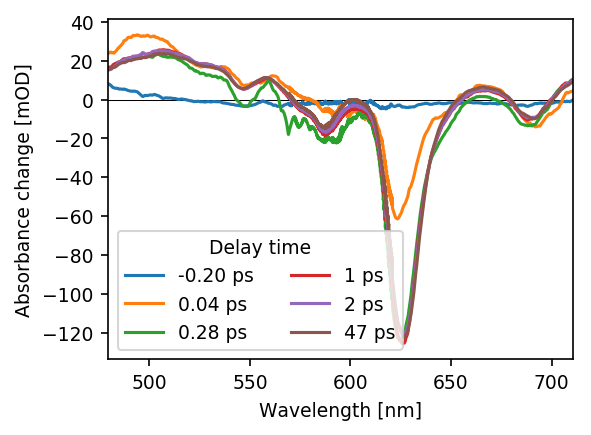

In [11]:
lines = res.correct_ds.plot.spec([-.2, 0.05, 0.3, 1, 2, 150])

Or plot transients for given wavelengths:

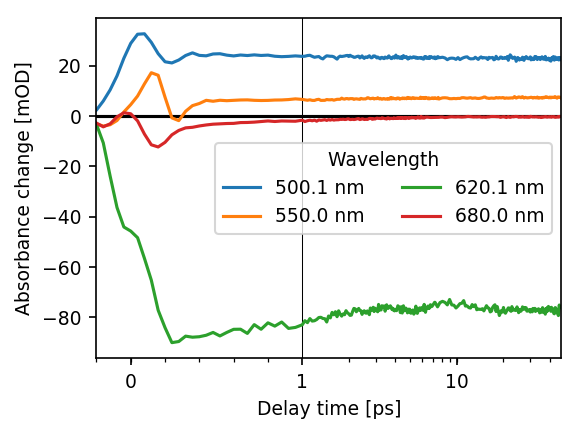

In [12]:
lines = res.correct_ds.plot.trans([500, 550, 620, 680])

All these function offer a number of options. More info is avaible in the docstrings.

## Exponential fitting


__Note: The section is likly to change, since the current interface is still very rough.__

Fitting a decay-associated spectra is a one-liner in skultrafast. If the dataset is dispersion corrected,
only a starting guess is necessay.

In [13]:
fit_res = new_ds.fit_exp([-0.0, 0.05, 0.2, 2, 20, 10000])
fit_res.lmfit_res.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr
p0   0.03887     -inf      inf 0.0002316     True     None
t0    0.1227      0.1      inf 0.0007746     True     None
t1     1.071      0.1      inf 0.006016     True     None
t2     9.996      0.1      inf  0.08518     True     None
t3     1e+04      0.1      inf        0    False     None
w     0.1282        0      inf 0.0001115     True     None


### Plotting the DAS, using old skultrafast functions
This will change in the near future.

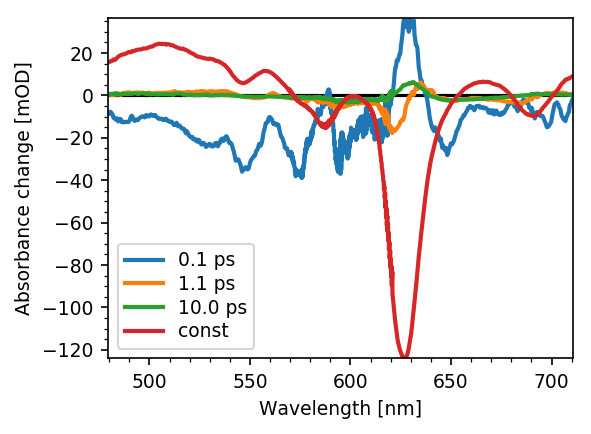

In [14]:
from skultrafast import plot_funcs, plot_helpers
plot_funcs.plot_das(fit_res.fitter, const=True)
plot_helpers.lbl_spec()

We can always work with the results directly to make plots manually. Here, the `t_idx`, `wl_idx` and `wn_idx` methods of the dataset are very useful:

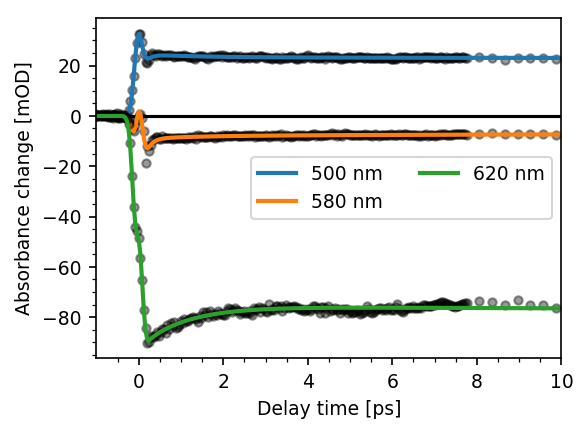

In [15]:
for wl in [500, 580, 620]:
    t0 = fit_res.lmfit_res.params['p0'].value
    idx = new_ds.wl_idx(wl)
    plt.plot(new_ds.t - t0, fit_res.fitter.data[:, idx], 'o', color='k', ms=4, alpha=0.4)
    plt.plot(new_ds.t - t0, fit_res.fitter.model[:, idx], lw=2, label='%d nm'%wl)
plt.xlim(-1, 10)
plt.legend(loc='best', ncol=2)
plot_helpers.lbl_trans(use_symlog=False)